# Задание 1.
У нас есть данные АА-теста с '2022-01-07' по '2022-01-13'. Вам нужно сделать симуляцию, как будто мы провели 10000 АА тестов. 
На каждой итерации вам нужно сформировать подвыборки с повторением в 500 юзеров из 2 и 3 экспериментальной группы. 
Провести сравнение этих подвыборок t-testом. 

### Задача:
1. Построить гистограмму распределения получившихся 10000 p-values.
2. Посчитать, какой процент p values оказался меньше либо равен 0.05
3. Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.

### 1. Подготовка к работе

In [79]:
# Подгружаем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandahouse
from scipy import stats

### 2. Загрузка данных

In [80]:
# Подключение к БД
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': '*****************'
}

# Запрос к БД
query = '''
SELECT user_id,
       exp_group,
       countIf(user_id, action = 'like' ) as like,
       countIf(user_id, action = 'view' ) as view,
       like/view as ctr
FROM simulator_20220120.feed_actions
WHERE (toDate(time) >= '2022-01-07' AND toDate(time) <= '2022-01-13' 
AND exp_group in [2,3])
GROUP BY user_id, exp_group
'''

# Создание датафрейма
df = pandahouse.read_clickhouse(query, connection=connection)

In [81]:
# Проверка df
df

,user_id,exp_group,like,view,ctr
0,115383,3,11,36,0.305556
1,123580,3,15,92,0.163043
2,131473,2,26,148,0.175676
3,23985,2,12,66,0.181818
4,24523,2,17,120,0.141667
...,...,...,...,...,...
17044,122008,3,4,31,0.129032
17045,25383,2,16,57,0.280702
17046,122190,3,25,74,0.337838
17047,108927,2,8,33,0.242424


### 3. Анализ данных

Распределения для 2й и 3й экспериментальной группы

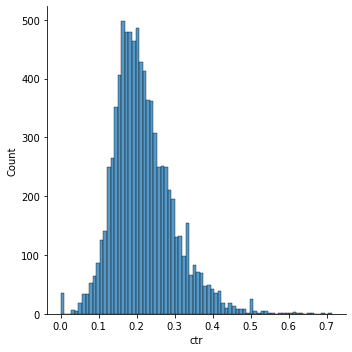

In [82]:
# Распределение экспериментальной группы 2
sns.displot(df[df.exp_group == 2].ctr, kde = False)

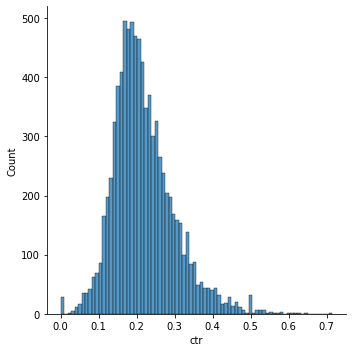

In [83]:
# Распределение экспериментальной группы 3
sns.displot(df[df.exp_group == 3].ctr, kde = False)

Xарактер распределения и медиана схожие. В целом явных визуальных различий в распределениях между экспериментальными группами не замечено

In [90]:
%%time

# Проводим выборку с повторениями в экспериментальных группах 2 и 3
count_tests = 10000
n_samples = 500
ctr_list = []
for i in range(count_tests):
    first_group = df[df.exp_group == 2].ctr.sample(n_samples, replace=True)
    secong_group = df[df.exp_group == 3].ctr.sample(n_samples, replace=True)
    p_val = stats.ttest_ind(first_group, secong_group, equal_var = False)[1]
    ctr_list.append(p_val)

CPU times: user 24.4 s, sys: 36 ms, total: 24.5 s
Wall time: 24.5 s


**Задача 1. Гистограмма 10000 p-values**

0.0546


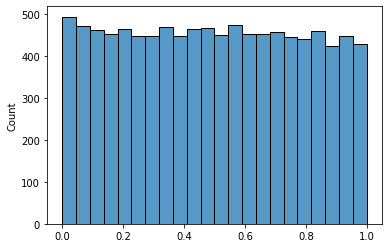

In [91]:
# тестов 10000, подвыворока 500
print(((pd.Series(ctr_list) <= 0.05).sum() / len(ctr_list)))
sns.histplot(ctr_list);

**Задача 2. Процент случаев, когда p-values меньше либо равен 0.05**

In [92]:
p_value = ((pd.Series(ctr_list) <= 0.05).sum() / len(ctr_list))
p_value

0.0546

**Задача 3. Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.** 

**Вывод:**
Полученная гистограмма позволяет сделать вывод, что p-value распространено равномерно. А при проверке системы 
сплитования было установлено, что в 5.37% случаях p-value меньше или равно заданному порогу альфра 0.05.
Вывод: система сплитования работает корректно.

## BONUS:
    

Проверка процента p-value < 0.05 в зависимости от количества наблюдений

### Сравнение ttest_ind

In [68]:
def check_split(n_samples, n_tests = 10000):
    ctr_list = []
    for i in range(n_tests):
        first_group = df[df.exp_group == 2].ctr.sample(n_samples, replace=True)
        secong_group = df[df.exp_group == 3].ctr.sample(n_samples, replace=True)
        p_val = stats.ttest_ind(first_group, secong_group, equal_var = False)[1]
        ctr_list.append(p_val)
    print('Прокрас AA-теста:', round((pd.Series(ctr_list) <= 0.05).sum() / len(ctr_list) * 100, 3), '%')
    sns.histplot(ctr_list);

Прокрас AA-теста: 4.39 %


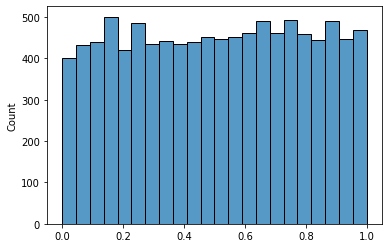

In [69]:
check_split(n_samples = 10, n_tests = 10000)

Прокрас AA-теста: 5.09 %


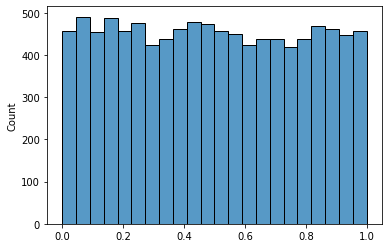

In [70]:
check_split(n_samples = 500, n_tests = 10000)

Прокрас AA-теста: 7.74 %


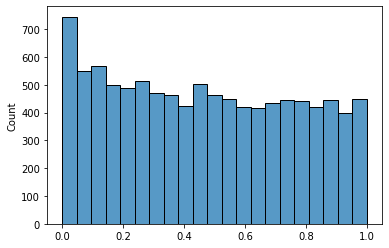

In [71]:
check_split(n_samples = 3000, n_tests = 10000)

Прокрас AA-теста: 10.42 %


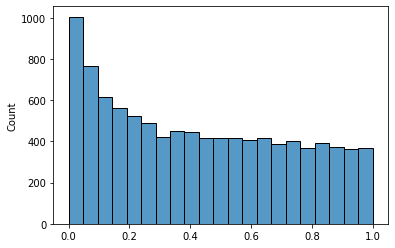

In [72]:
check_split(n_samples = 8000, n_tests = 10000)

### Сравнение mannwhitneyu

In [87]:
def check_split_MW(n_samples, n_tests = 10000):
    ctr_list = []
    for i in range(n_tests):
        first_group = df[df.exp_group == 2].ctr.sample(n_samples, replace=True)
        secong_group = df[df.exp_group == 3].ctr.sample(n_samples, replace=True)
        p_val = stats.mannwhitneyu(first_group, secong_group)[1]
        ctr_list.append(p_val)
    print('Прокрас AA-теста:', round((pd.Series(ctr_list) <= 0.05).sum() / len(ctr_list) * 100, 3), '%')
    sns.histplot(ctr_list);

Прокрас AA-теста: 4.31 %


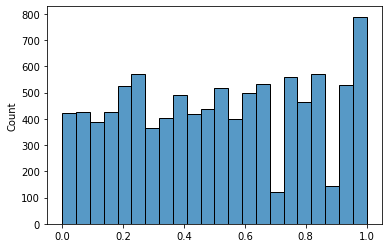

In [97]:
check_split_MW(n_samples = 10, n_tests = 10000)

Прокрас AA-теста: 5.59 %


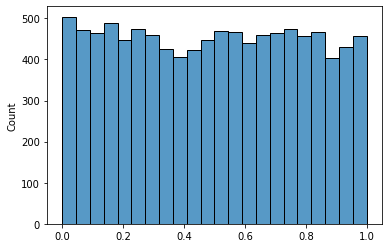

In [98]:
check_split_MW(n_samples = 500, n_tests = 10000)

Прокрас AA-теста: 6.56 %


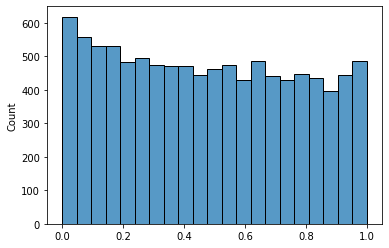

In [99]:
check_split_MW(n_samples = 3000, n_tests = 10000)

Прокрас AA-теста: 9.47 %


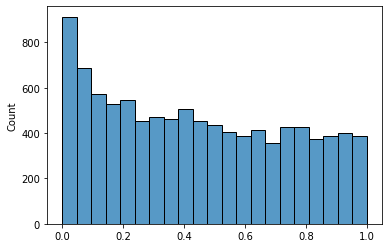

In [100]:
check_split_MW(n_samples = 8000, n_tests = 10000)